# Step 1

In [1]:
import numpy as np
from transformers import AutoTokenizer, AutoModel
from scipy.spatial.distance import cosine
import os
import pandas as pd
import openai
import matplotlib.pyplot as plt

# Provide data -> EDA & Generating raw questions
- GPT3.5에 한의원 data(csv) 제공 
- EDA & 초기 날질문 생성

#### 함수 정의

In [2]:
def gpt_answer(msg):

    openai.api_key="****"

    answer = []

    completion = openai.ChatCompletion.create(
        model = "gpt-3.5-turbo",
        messages=[{"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": msg}]
        )

    for choice in completion.choices:
        print(choice['message']['content'])
        answer.append(choice['message']['content'].strip())

    return answer

def csv_reading(path):
    df = pd.read_csv(path)
    df = df.drop(['fk_id'], axis = 1)
    return df


def compare_graph(path):

    # Read the CSV file
    data = pd.read_csv(path)

    # Extract the data for x and y axes from the CSV columns
    x_values = data.iloc[:, 1]  # Assuming x-values are in the first column
    y_values = data.iloc[:, 2]  # Extract y-values from the second column

    # Create the bar graph
    plt.bar(x_values, y_values)

    # Rotate x-axis labels
    plt.xticks(rotation=90)

    # Add labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Bar Graph from CSV Data')

    # Display the graph
    plt.show()

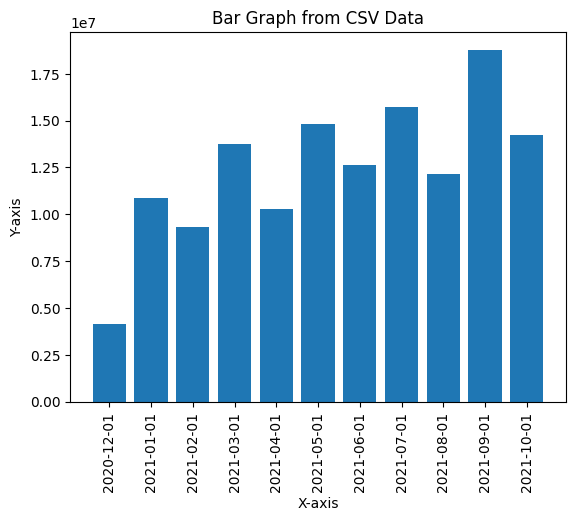

1. 2020년 12월 이후에 비급여 총매출이 급격히 상승한 이유가 무엇인가요?
2. 2021년 3월과 5월 사이에 비급여 총매출이 크게 증가한 이유가 있나요?
3. 2021년 9월 비급여 총매출이 이전 달 대비 큰 폭으로 증가한 이유가 있나요?
4. 2021년 상반기와 하반기 비급여 총매출의 차이가 큰 이유가 무엇인가요?
5. 2018년부터 2021년까지 전반적인 비급여 총매출의 추세는 어떤가요? 변화가 있는지 분석해보세요.


In [3]:
path = '/home/fastcampus/Test_model /매출 데이터셋/비급여 총매출.csv/365송도경희한의원 비급여 총매출.csv'
df = csv_reading(path)

prompt = f"다음 주어지는 테이블은 csv 형식의 테이블이야 {df.to_string(index=False)}.  이 테이블에서 'biz_dt'는 '날짜'를 의미하며, 'nonbenefit_total_pay'는 '비급여 총매출'을 의미해. 위 테이블 데이터를 종합하여 특이점과 변동하는 값들에 기반하여 이 병원을 위한 피드백 질문 5가지를 생성해줘. 이때, 값이 없는 부분은 무시하고, 구체적인 날짜를 언급해줘."

compare_graph(path)
raw_qs = gpt_answer(prompt)

In [4]:
# 결과를 저장할 리스트
raw_qs_list = []

# 각 항목에 대해 '\n'을 기준으로 분할
for sentences in raw_qs:
    split_sentences = sentences.split('\n')
    raw_qs_list.extend(split_sentences)

# 결과 출력
for sentence in raw_qs_list:
    print(sentence)

1. 2020년 12월 이후에 비급여 총매출이 급격히 상승한 이유가 무엇인가요?
2. 2021년 3월과 5월 사이에 비급여 총매출이 크게 증가한 이유가 있나요?
3. 2021년 9월 비급여 총매출이 이전 달 대비 큰 폭으로 증가한 이유가 있나요?
4. 2021년 상반기와 하반기 비급여 총매출의 차이가 큰 이유가 무엇인가요?
5. 2018년부터 2021년까지 전반적인 비급여 총매출의 추세는 어떤가요? 변화가 있는지 분석해보세요.


# Transformer - KLUE (Pretrained Model)
- 기업에서 실제로 쓰이는 질문 중, 날질문과 유사한 질문 찾기

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("KLUE/roberta-base")
model = AutoModel.from_pretrained("KLUE/roberta-base")

def get_sentence_embedding(sentence):
    if not isinstance(sentence, str):
        #print("문장은 문자열로 입력해주세요.")
        pass
        return None

    if not sentence.strip():
        #print("비어있는 문자열은 처리할 수 없습니다.")
        pass
        return None

    inputs = tokenizer(sentence, return_tensors="pt")
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(axis=1).detach().numpy()
    return embeddings.reshape(-1)

input_questions = raw_qs_list

questions_df = pd.read_csv("train_question.csv")
questions = questions_df["질문"].tolist()

def get_top5_similar_questions(embed_question, questions):
    if embed_question is None:
        return [], []

    similarities = []

    for question in questions:
        embed = get_sentence_embedding(question)
        if embed is not None:
            similarity = 1 - cosine(embed_question, embed)
        else:
            similarity = 0
        similarities.append(similarity)

    top5_indexes = np.argsort(similarities)[-5:][::-1]
    top5_questions = [questions[i] for i in top5_indexes]
    top5_similarities = [similarities[i] for i in top5_indexes]

    return top5_questions, top5_similarities

def print_top5_similar_questions(input_question, embed_input_question, questions):
    top5_questions, top5_similarities = get_top5_similar_questions(embed_input_question, questions)

    print(f"\n{input_question}와 가장 유사한 5개 질문:")
    for i, (question, similarity) in enumerate(zip(top5_questions, top5_similarities)):
        print(f"Top{i + 1} 유사 질문: {question} (유사도: {similarity:.2f})")

for input_question in input_questions:
    embed_input_question = get_sentence_embedding(input_question)
    print_top5_similar_questions(input_question, embed_input_question, questions)




Some weights of the model checkpoint at KLUE/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at KLUE/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for


1. 2020년 12월부터 2021년 9월까지 비급여 총매출이 크게 상승했는데, 이유가 무엇인가요?와 가장 유사한 5개 질문:
Top1 유사 질문: 전달대비 비급여매출이 39.9% 하락했습니다. 하락 요인이 무엇인가요? 작년 8월은 최고치를 경신했던 비급여 지표라, 어떤 차이가 있는지 여쭤봅니다. (유사도: 0.90)
Top2 유사 질문: 4월 비급여가 가파르게 상승하여 최고기록 경신하셨습니다. 보약매출에 직접적으로 기여한 요소 무엇일까요? (유사도: 0.90)
Top3 유사 질문: 총진료비와 비급여매출이 역대 최고 기록을 달성했습니다. 일반한약의 상승이 지속되고 이번달 최고매출액을 달성하였는데, 가정의달 이벤트의 연관성과 비중이 어떻게 되는 지 궁금합니다. (유사도: 0.89)
Top4 유사 질문: 총매출과 비급여가 비슷한 경향성을 띕니다. 지난달 상승했던 한약 전환율이 유지되지 못한 이유는 뭘까요? 그리고 9월부터 재결제 데이터가 없는데요. 입력이 중단된 것일까요? (유사도: 0.89)
Top5 유사 질문: 비급여 항목 중 다이어트는 9월부터 두달째 매출이 없는 상태입니다. 요인이 무엇인가요? (유사도: 0.89)

2. 2021년 3월과 5월에 비급여 총매출이 갑자기 많이 증가했는데, 이는 어떤 원인 때문인가요?와 가장 유사한 5개 질문:
Top1 유사 질문: 전달대비 비급여매출이 39.9% 하락했습니다. 하락 요인이 무엇인가요? 작년 8월은 최고치를 경신했던 비급여 지표라, 어떤 차이가 있는지 여쭤봅니다. (유사도: 0.91)
Top2 유사 질문: 총진료비와 비급여매출이 역대 최고 기록을 달성했습니다. 일반한약의 상승이 지속되고 이번달 최고매출액을 달성하였는데, 가정의달 이벤트의 연관성과 비중이 어떻게 되는 지 궁금합니다. (유사도: 0.90)
Top3 유사 질문: 총매출과 비급여가 비슷한 경향성을 띕니다. 지난달 상승했던 한약 전환율이 유지되지 못한 이유는 뭘까요? 그리고 9월부터 재결제 데이터가 없는데요. 입력이 중단된 것일까요? (유사도: 0.9

# Fewshot Learning
- 위 질문들 중, 유사도 높은 8개를 추려 GPT Fewshot Learning

In [6]:
# GPT Fewshot-Learning

test_data = pd.read_csv("/home/fastcampus/Test_model /매출 데이터셋/비급여 총매출.csv/365송도경희한의원 비급여 총매출.csv")

klue_questions = """
1. 큰 폭으로 비급여 매출이 증가하게 된 원인은 무엇이라고 판단하시나요? 
2. 전달대비 비급여매출이 39.9% 하락했습니다. 하락 요인이 무엇인가요? 작년 8월은 최고치를 경신했던 비급여 지표라, 어떤 차이가 있는지 여쭤봅니다. 
3. 비급여 매출의 영향으로 총매출이 줄었습니다. 비급여 전반적으로 감소한 것 같은데요. 무엇 때문인가요? 
4. 큰 폭으로 비급여 매출이 증가하게 된 원인은 무엇이라고 판단하시나요? 
5. 총 진료비의 상승은 비급여매출의 상승과 연관이 있지만 3월달 대비 환자당 총진료비 금액이 낮아지며 총매출 추세의 변동이 없었습니다. 현재로는 비급여매출을 높이는게 방법으로 보입니다. 이를 위한 개선전략이 있으신가요? 구체적으로 우리가 3월만큼 비급여 지표를 달성하려면 어떻게 해야할까요? 
6. 총매출과 비급여가 비슷한 경향성을 띕니다. 지난달 상승했던 한약 전환율이 유지되지 못한 이유는 뭘까요? 그리고 9월부터 재결제 데이터가 없는데요. 입력이 중단된 것일까요? 
7. 3월 비급여 상담건수 상승요인이 무엇인가요?
8. 큰 폭으로 비급여 매출이 증가하게 된 원인은 무엇이라고 판단하시나요? 
"""

conversation = [
    {
        "role": "system",
        "content": "아래 주어지는 테이블에서 'biz_dt'는 '날짜', 'nonbenefit_total_pay'는 '비급여 총매출'을 의미해. 'nonbenefit_total_pay'값이 없는 부분은 언급하면 안돼."
    },
    {
        "role": "user",
        "content": f"""
        아래 테이블 데이터를 종합하여 증감률이나 큰 특이점을 기준으로 경영을 위한 창의적인 피드백 질문들을 5개 생성해줘.
        생성 예시 : {klue_questions}
        데이터 테이블 :
        {test_data}
        """
    },
    {
        "role": "assistant",
        "content": "..."
    }
]

import openai
openai.api_key="****"

response = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=conversation
)

print(response['choices'][0]['message']['content'])

1. 2021년 1월을 기준으로 비급여 매출이 크게 증가했는데, 이러한 증가는 어떤 책임과 목적으로 이루어졌나요? 
2. 2021년 2월 비급여 매출이 가장 낮았는데 이러한 감소는 어떤 요인에서 비롯됐나요? 이에 따른 비급여 매출의 추세 변화 예상치는 어떻게 되나요?
3. 비급여 총매출이 계속해서 상승하고 있긴 하지만 차이가 매우 큽니다. 원인을 파악하여 비급여 매출을 더 증가시키기 위한 전략이 있나요?
4. 데이터 상으로 비급여 매출 증감률이 큰 것으로 보입니다. 이러한 변동이 있기 전과 후의 예산 분석 등 경영에 대한 전략적인 대안을 강구하고 있는 건가요?
5. 2021년 9월 부터 비급여 매출이 비약적으로 증가한데, 이러한 비율상승은 어떤 영향 요인이 있었나요? 그리고 이러한 경향은 추후에도 유지될지 예상이 되나요?
